In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import momepy
import libpysal
from tqdm import tqdm

In [2]:
from sklearn import preprocessing

In [3]:
from clustergram import Clustergram

In [4]:
chunks = gpd.read_parquet('../../urbangrammar_samba/spatial_signatures/local_auth_chunks.pq')

In [3]:
chunks

,geometry,chunkID
lbls,,
0.0,"POLYGON ((347746.989 428617.983, 347611.489 42...",0
1.0,"POLYGON ((466755.502 343585.209, 466723.708 34...",1
2.0,"POLYGON ((492814.052 165900.388, 492653.958 16...",2
3.0,"POLYGON ((555738.312 145126.176, 555646.807 14...",3
4.0,"POLYGON ((539183.091 274691.315, 539231.597 27...",4
...,...,...
98.0,"POLYGON ((416824.197 290592.777, 416904.996 29...",98
99.0,"POLYGON ((377928.269 131214.407, 377903.871 13...",99
100.0,"POLYGON ((356179.971 588517.721, 356353.165 58...",100


In [5]:
from shapely.geometry import Point

nhmptn = gpd.GeoSeries([Point(-0.9087, 52.2375)], crs=4326).to_crs(27700)

In [7]:
chunks[chunks.intersects(nhmptn[0])]

,geometry,chunkID
lbls,,
8.0,"POLYGON ((496531.705 246753.398, 496484.411 24...",8


In [8]:
lon = gpd.GeoSeries([Point(-0.12807355616611568, 51.50604696235029)], crs=4326).to_crs(27700)
chunks[chunks.intersects(lon[0])]

,geometry,chunkID
lbls,,
15.0,"POLYGON ((529406.101 170556.868, 529402.220 17...",15


In [8]:
data = gpd.read_parquet("../../urbangrammar_samba/spatial_signatures/morphometrics/cells/cells_8.pq")

In [9]:
data.columns

Index(['hindex', 'tessellation', 'buildings', 'sdbAre', 'sdbPer', 'sdbCoA',
       'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD',
       'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri', 'sicCAR',
       'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE', 'ltbIBD',
       'nodeID', 'sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL',
       'mtdDeg', 'lcdMes', 'linP3W', 'linP4W', 'linPDE', 'lcnClo', 'ldsCDL',
       'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 'edgeID_keys', 'edgeID_values',
       'edgeID_primary', 'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre', 'ltcRea', 'ltcAre', 'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe'],
      dtype='object')

In [10]:
characters = ['sdbAre', 'sdbPer', 'sdbCoA',
       'ssbCCo', 'ssbCor', 'ssbSqu', 'ssbERI', 'ssbElo', 'ssbCCM', 'ssbCCD',
       'stbOri', 'sdcLAL', 'sdcAre', 'sscCCo', 'sscERI', 'stcOri', 'sicCAR',
       'stbCeA', 'mtbAli', 'mtbNDi', 'mtcWNe', 'mdcAre', 'ltcWRE', 'ltbIBD',
       'sdsSPW', 'sdsSWD', 'sdsSPO', 'sdsLen', 'sssLin', 'ldsMSL',
       'mtdDeg', 'lcdMes', 'linP3W', 'linP4W', 'linPDE', 'lcnClo', 'ldsCDL',
       'xcnSCl', 'mtdMDi', 'lddNDe', 'linWID', 
        'stbSAl', 'sddAre', 'sdsAre', 'sisBpM', 'misCel',
       'mdsAre', 'lisCel', 'ldsAre', 'ltcRea', 'ltcAre', 'ldeAre', 'ldePer',
       'lseCCo', 'lseERI', 'lseCWA', 'lteOri', 'lteWNB', 'lieWCe']

In [12]:
gdf = gpd.GeoDataFrame(data[characters], geometry=data.tessellation.centroid)
%time W = momepy.sw_high(k=10, weights=libpysal.weights.Queen.from_dataframe(data, geom_col='tessellation'))

/opt/conda/lib/python3.8/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 15 disconnected components.
 There are 9 islands with ids: 146559, 147775, 147875, 147883, 147901, 148577, 149323, 149342, 149349.
  warnings.warn(message)


CPU times: user 5min 44s, sys: 10.7 s, total: 5min 55s
Wall time: 5min 55s


In [15]:
convolutions = {}
for c in characters:
    convolutions[c] = []

# measure convolutions
for i, geom in tqdm(gdf.geometry.iteritems(), total=data.shape[0]):
    neighbours = W.neighbors[i]
    vicinity = gdf.iloc[neighbours]
    distance = vicinity.distance(geom)
    distance_decay = 1 / distance
    
    for c in characters:
        values = vicinity[c].values
        sorter = np.argsort(values)
        values = values[sorter]
        nan_mask = np.isnan(values)
        if nan_mask.all():
            convolutions[c].append(np.array([np.nan] * 3))
        else:
            sample_weight = distance_decay.values[sorter][~nan_mask]
            weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
            weighted_quantiles /= np.sum(sample_weight)
            interpolate = np.interp([.25, .5, .75], weighted_quantiles, values[~nan_mask])
            convolutions[c].append(interpolate)

 33%|███▎      | 48833/149525 [04:55<09:24, 178.38it/s]<ipython-input-15-07ef19d7cbf0>:21: RuntimeWarning: invalid value encountered in subtract
  weighted_quantiles = np.cumsum(sample_weight) - 0.5 * sample_weight
<ipython-input-15-07ef19d7cbf0>:22: RuntimeWarning: invalid value encountered in true_divide
  weighted_quantiles /= np.sum(sample_weight)
100%|██████████| 149525/149525 [15:16<00:00, 163.08it/s]


In [16]:
%time conv = pd.DataFrame(convolutions, index=data.index)
%time exploded = pd.concat([pd.DataFrame(conv[c].to_list(), columns=[c + '_q1', c + '_q2',c + '_q3']) for c in characters], axis=1)

CPU times: user 1.87 s, sys: 44 ms, total: 1.91 s
Wall time: 1.91 s
CPU times: user 11.9 s, sys: 356 ms, total: 12.3 s
Wall time: 12.3 s


In [20]:
scaler = preprocessing.StandardScaler()

In [21]:
scaled_data = scaler.fit_transform(exploded)

In [22]:
mask = gdf.within(Point(475000, 260000).buffer(10000))

In [23]:
nh_data = scaled_data[mask]

In [24]:
nh_data.shape

(36396, 177)

In [26]:
nulls = np.isnan(nh_data)
nh_data[nulls] = 0

In [27]:
cg = Clustergram(range(1, 15), n_init=10)
cg.fit(nh_data)

K=1 fitted in 1.0541980266571045 seconds.
K=2 fitted in 1.1690411567687988 seconds.
K=3 fitted in 1.663944959640503 seconds.
K=4 fitted in 1.7653963565826416 seconds.
K=5 fitted in 2.0640511512756348 seconds.
K=6 fitted in 2.0697145462036133 seconds.
K=7 fitted in 2.2315945625305176 seconds.
K=8 fitted in 2.809513568878174 seconds.
K=9 fitted in 2.948035955429077 seconds.
K=10 fitted in 3.0751941204071045 seconds.
K=11 fitted in 3.4062979221343994 seconds.
K=12 fitted in 3.78933048248291 seconds.
K=13 fitted in 3.949535846710205 seconds.
K=14 fitted in 4.091408967971802 seconds.


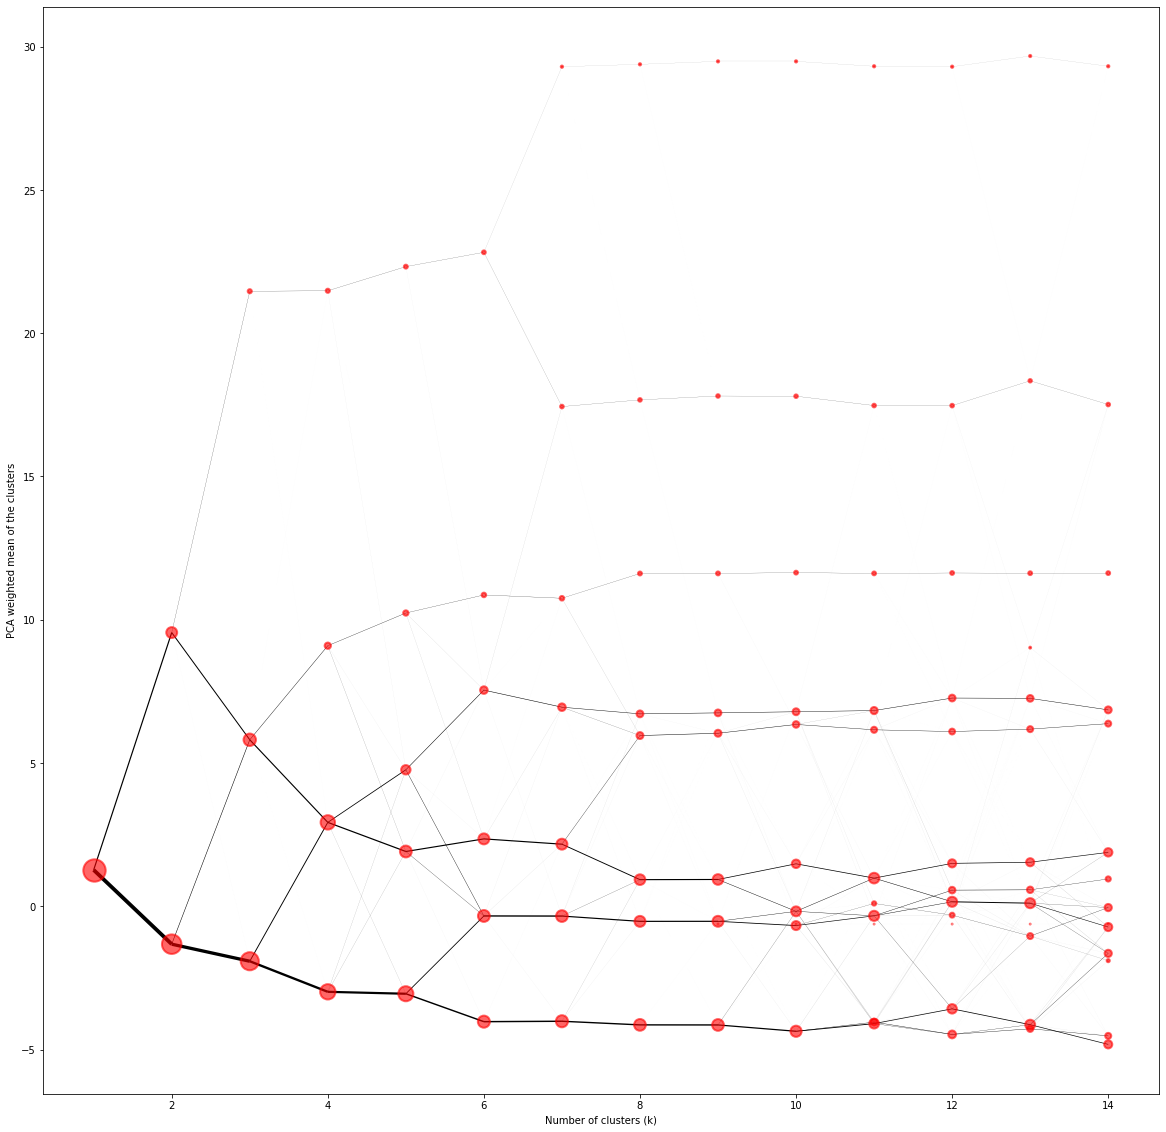

In [29]:
ax = cg.plot(figsize=(20, 20), linewidth=0.1, cluster_style={"edgecolor": "r", "alpha":.6}, size=1)
# ax.set_ylim(-10, 50)

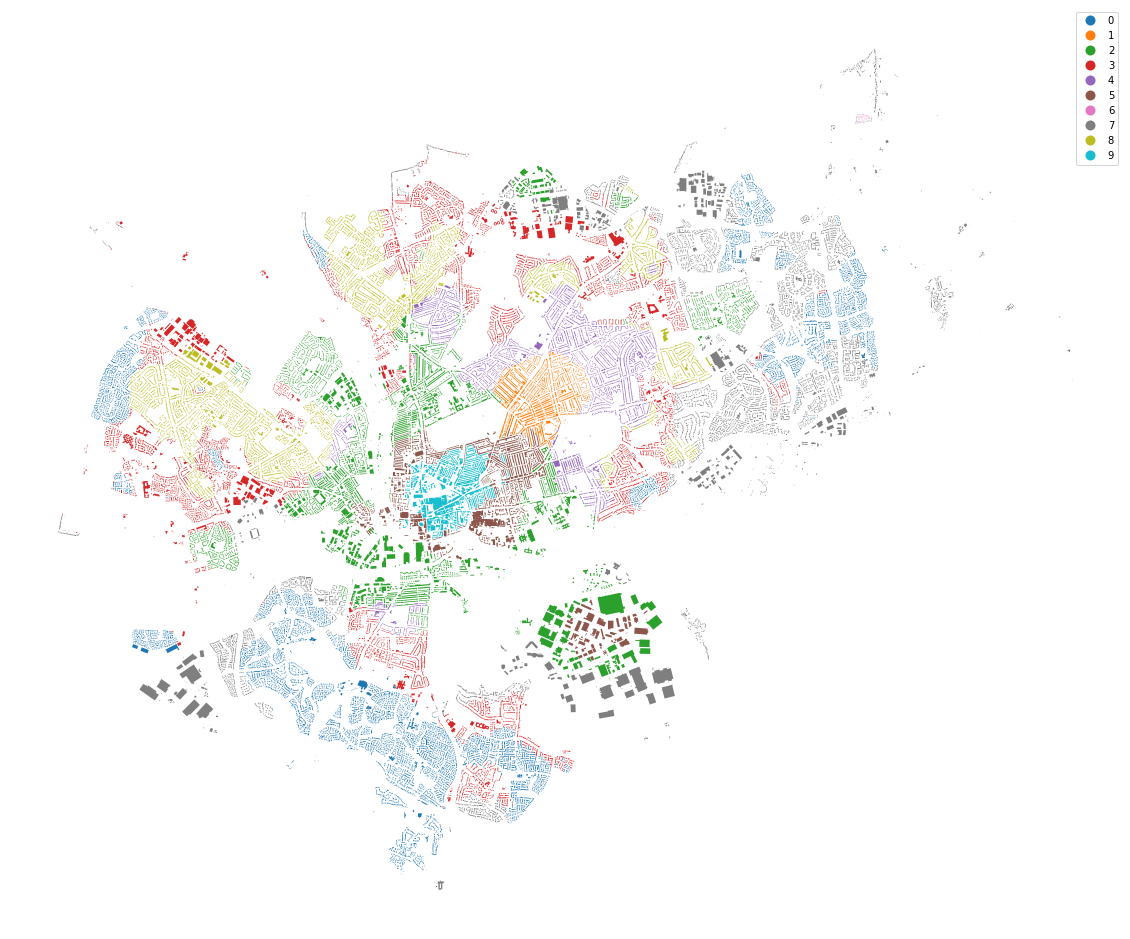

In [40]:
ax = nh.set_geometry('buildings').plot(cg.labels[10], categorical=True, legend=True, figsize=(20, 20), cmap='tab10')
ax.set_axis_off()

In [31]:
from sklearn.cluster import KMeans

In [32]:
km = KMeans(n_clusters=7, n_init=1000).fit(nh_data)

In [33]:
nh = data[mask]

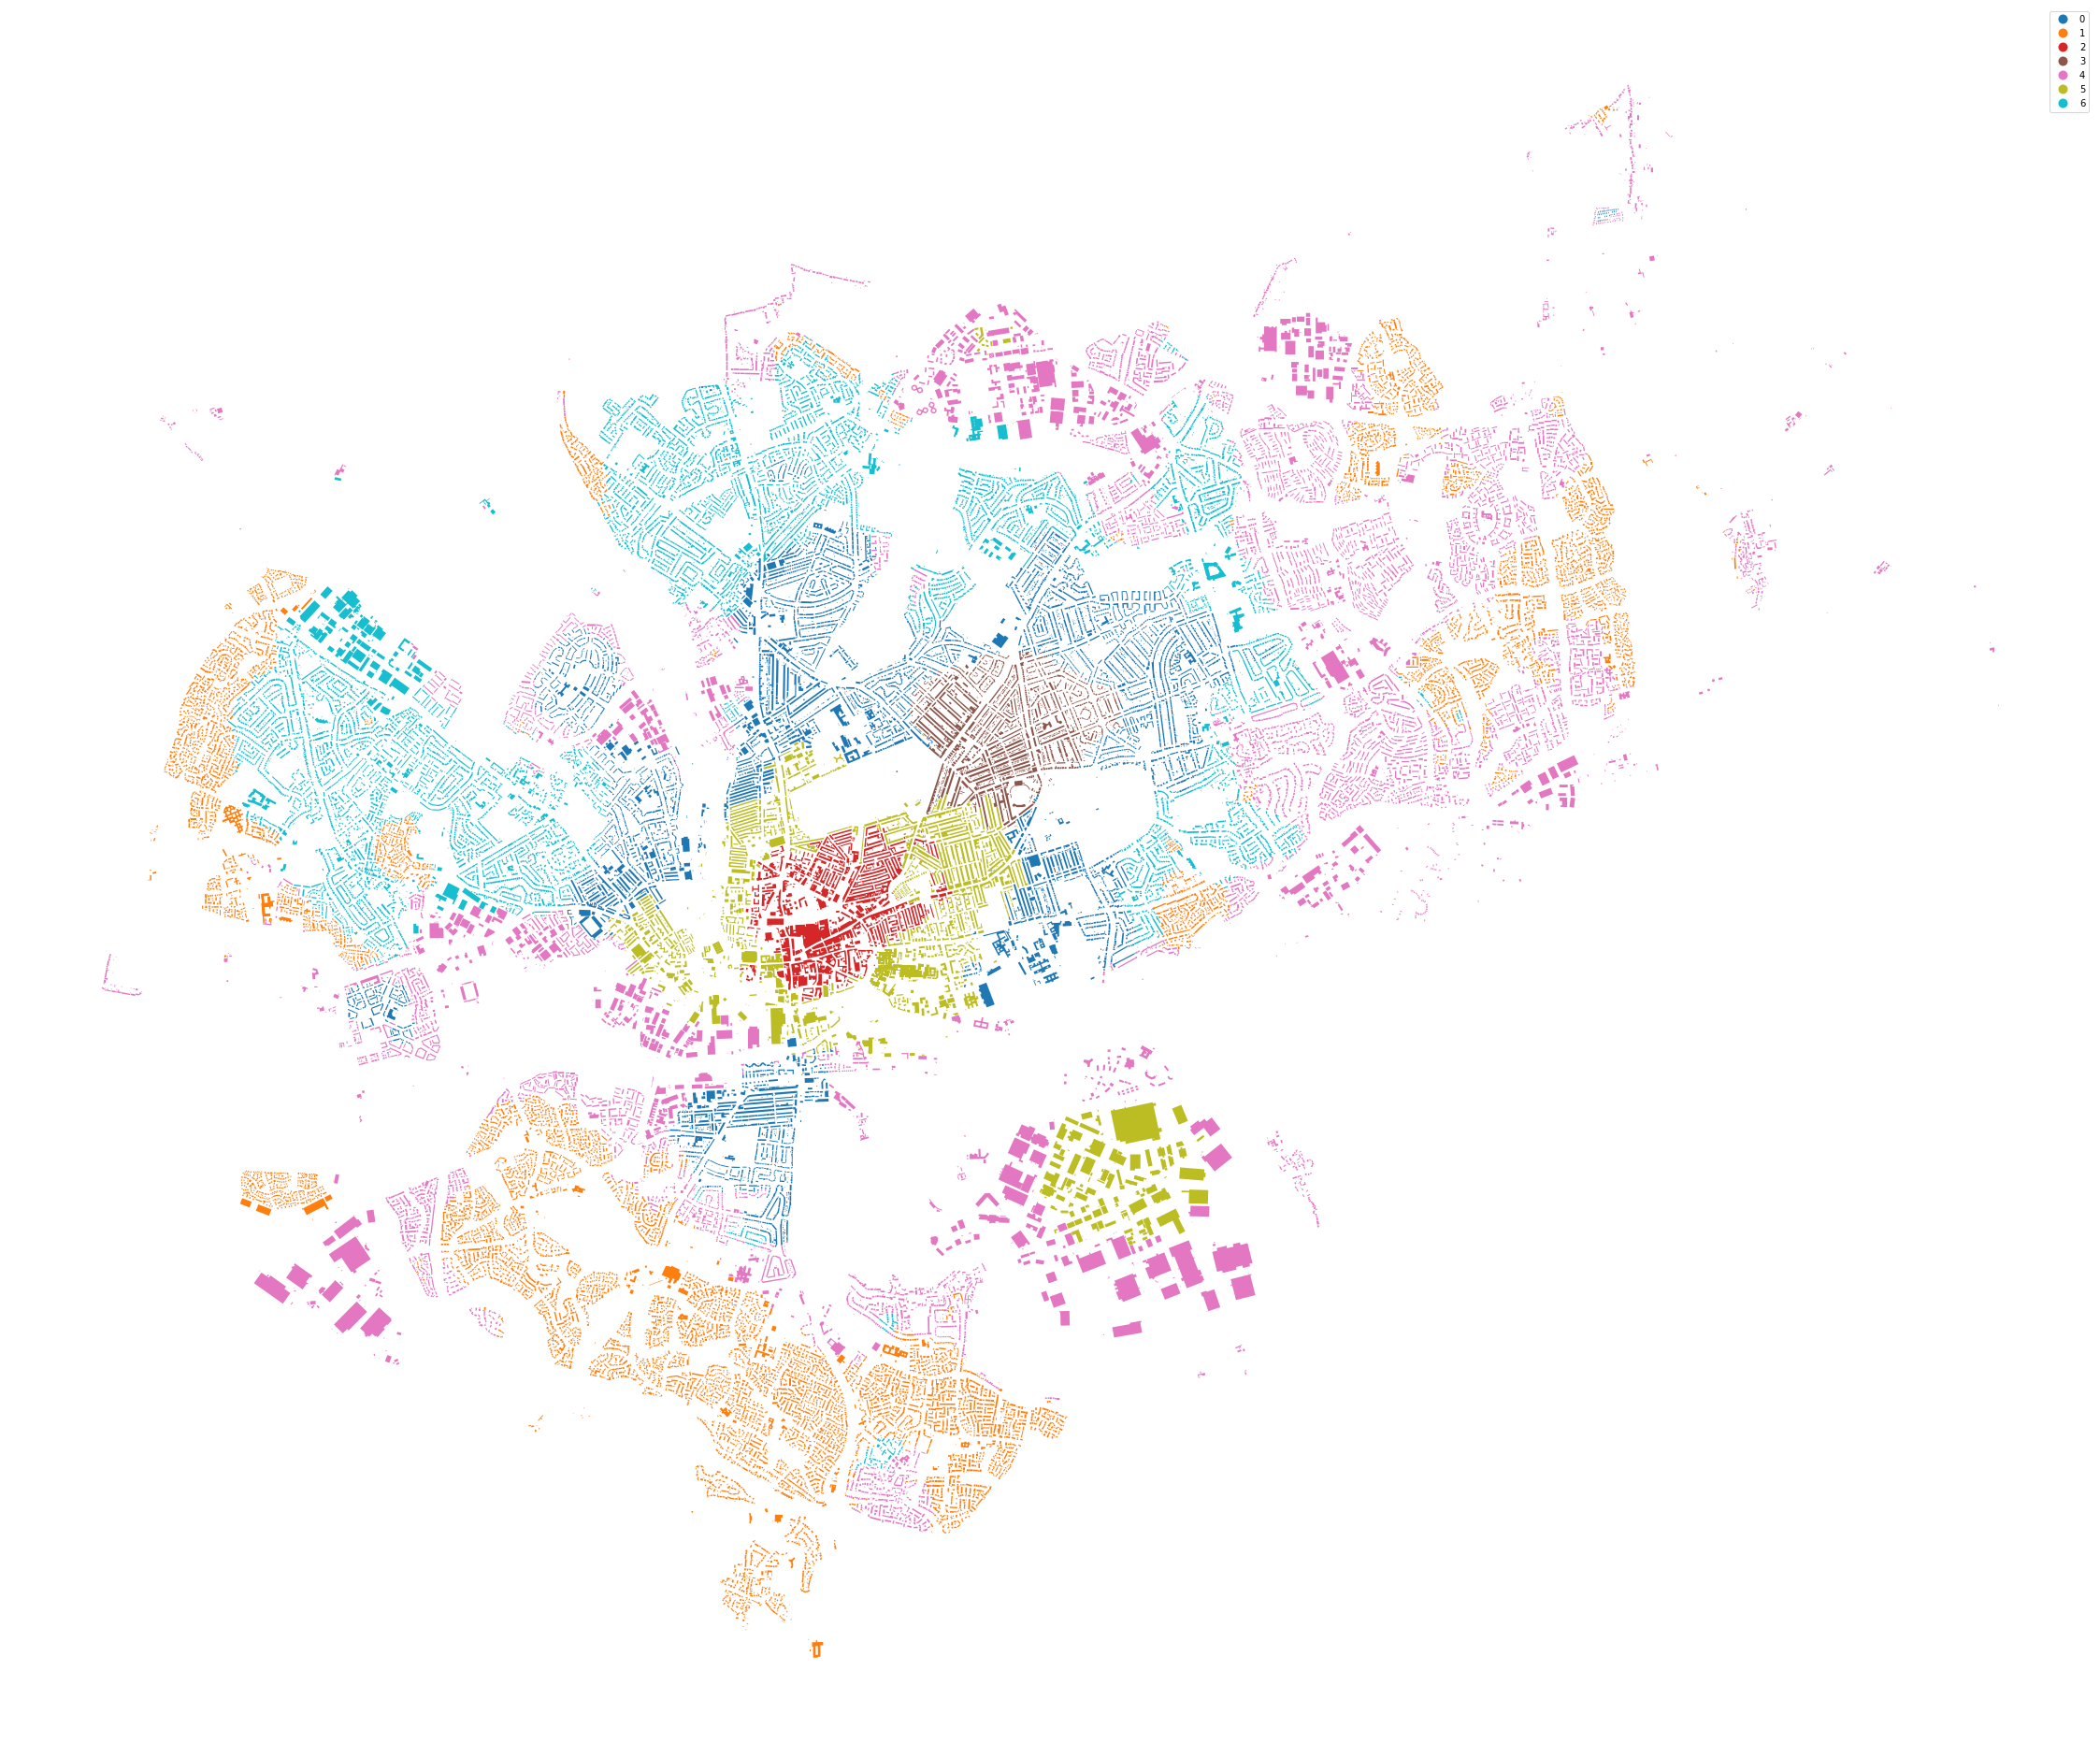

In [35]:
ax = nh.set_geometry('buildings').plot(km.labels_, categorical=True, legend=True, figsize=(40, 40), cmap='tab10')
ax.set_axis_off()

In [36]:
nh['clusters'] = km.labels_

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [39]:
nh.set_geometry("buildings")[['clusters', 'buildings']].to_file('north.gpkg', driver='GPKG')

In [37]:
nh

,hindex,tessellation,buildings,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,...,ltcAre,ldeAre,ldePer,lseCCo,lseERI,lseCWA,lteOri,lteWNB,lieWCe,clusters
84662,c008e296665t0017,"POLYGON ((475063.154 255443.046, 475060.757 25...","POLYGON ((475064.670 255467.970, 475056.670 25...",280.5151,78.386230,0.0,0.469208,6.0,1.964106,0.861559,...,1.099443e+05,230190.13020,2219.298778,0.365673,0.915068,470.424165,27.410684,0.000901,0.001688,1
84663,c008e296665t0016,"POLYGON ((475077.010 255439.660, 475088.837 25...","POLYGON ((475068.410 255437.200, 475053.700 25...",159.2342,52.583478,0.0,0.543714,4.0,0.026469,1.000000,...,1.346705e+05,230190.13020,2219.298778,0.365673,0.915068,470.424165,27.410684,0.000901,0.001688,1
84664,c008e296665t0007,"POLYGON ((475273.021 255120.606, 475272.310 25...","POLYGON ((475050.870 255285.670, 475055.950 25...",32.3360,22.831995,0.0,0.626878,4.0,0.021263,1.000014,...,4.332612e+06,230190.13020,2219.298778,0.365673,0.915068,470.424165,27.410684,0.000901,0.001688,1
84665,c008e296665t0014,"POLYGON ((475179.665 255349.022, 475193.973 25...","POLYGON ((475059.420 255334.190, 475069.960 25...",66.7386,36.176424,0.0,0.438568,4.0,0.020433,1.000031,...,2.671080e+06,230190.13020,2219.298778,0.365673,0.915068,470.424165,27.410684,0.000901,0.001688,1
84666,c008e296665t0013,"POLYGON ((475083.257 255463.821, 475082.489 25...","POLYGON ((475082.780 255465.110, 475084.850 25...",117.5740,59.514714,0.0,0.230033,4.0,0.766072,0.977062,...,1.027716e+05,230190.13020,2219.298778,0.365673,0.915068,470.424165,27.410684,0.000901,0.001688,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149391,c008e289820t0000,"POLYGON ((481527.770 266002.590, 481543.400 26...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,6.416343e+05,3604.86495,268.050518,0.346579,0.996149,54.144738,10.222169,0.003731,0.005447,4
149392,c008e289807t0000,"POLYGON ((481629.110 266057.120, 481642.870 26...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.349538e+06,16482.09960,807.206388,0.241512,0.685085,256.016369,8.639227,0.001239,0.001619,4
149393,c008e289821t0000,"POLYGON ((481731.300 266014.740, 481687.610 26...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.025636e+05,2982.11840,235.725664,0.432070,0.964060,38.862221,8.441331,0.029696,0.000050,4
149394,c008e289809t0000,"POLYGON ((481577.300 266077.680, 481586.530 26...",None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4.396889e+05,416.61140,95.855970,0.365981,0.854313,20.854425,43.755955,0.010432,0.000842,4
